### XGBoost

 - How boosting works:
     - Iterative learning a set of weak learners (e.g. decision trees) on subsets of the data
     - Weighing each weak learner prediction according to each learner's performance
     - Combine the weighted predictions to produce a single prediction (that outperforms any individual ones)


 - Learn more: https://en.wikipedia.org/wiki/XGBoost

In [42]:
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error

In [10]:
cure = load_breast_cancer()
features = pd.DataFrame(scale(cure['data']), columns = cure['feature_names'])
target = pd.DataFrame(cure['target'], columns=['Type'])
df = pd.concat([target,features],axis=1)
df.shape

(569, 31)

In [18]:
# Create arrays for the features and the response variable
y = target.values.reshape(-1)
X = features.iloc[:,:10].values

display(y.shape, X.shape)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123)

(569,)

(569, 10)

In [19]:
# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)

# Fit the classifier to the training set
xg_cl.fit(X_train,y_train)
xg_cl

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, ...)

In [14]:
# Predict the labels of the test set: preds
preds = xg_cl.predict(X_test)

# Compute the accuracy: accuracy
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

accuracy: 0.923977


In [20]:
# vs Dec Tree
from sklearn.tree import DecisionTreeClassifier

# Instantiate the classifier: dt_clf_4
dt_clf_4 = DecisionTreeClassifier(max_depth=4)

# Fit the classifier to the training set
dt_clf_4.fit(X_train, y_train)

# Predict the labels of the test set: y_pred_4
y_pred_4 = dt_clf_4.predict(X_test)

# Compute the accuracy of the predictions: accuracy
accuracy = float(np.sum(y_pred_4==y_test))/y_test.shape[0]
print("accuracy:", accuracy)


accuracy: 0.9064327485380117


DMatrix

cv_results stores the training and test mean and standard deviation of the error per boosting round (tree built) as a DataFrame. From cv_results, the final round 'test-error-mean' is extracted and converted into an accuracy, where accuracy is 1-error

In [17]:
# Create the DMatrix from X and y: churn_dmatrix
k_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:logistic", "max_depth":3}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=k_dmatrix, params=params, 
                    nfold=3, num_boost_round=5, 
                    metrics="error", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Print the accuracy
print(((1-cv_results["test-error-mean"]).iloc[-1]))

   train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.038668         0.006240         0.079096        0.004480
1          0.032521         0.006609         0.082586        0.008819
2          0.031639         0.003764         0.072060        0.015108
3          0.029885         0.006245         0.080850        0.021655
4          0.029001         0.002183         0.087868        0.008890
0.9121321823076209


In [21]:
# Perform cross_validation: cv_results
cv_results = xgb.cv(dtrain=k_dmatrix, params=params, 
                    nfold=3, num_boost_round=5, 
                    metrics="auc", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Print the AUC
print((cv_results["test-auc-mean"]).iloc[-1])

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.979070       0.001745       0.953747      0.010993
1        0.983713       0.004070       0.958822      0.007473
2        0.989433       0.005535       0.964176      0.011911
3        0.990700       0.006353       0.964271      0.011406
4        0.992352       0.004441       0.967090      0.006971
0.9670895250219335


#### XGBoost for regression problems

 - Objective functions:
     - Quantifies how far is an actual result from the prediction that is made
     - Measures the differences between estimated and true values for some collection of data
     - The goal is to find the model (i.e. its parameters) that minimizes the value of the loss function
 
 
 - Common loss functions in XGBoost
     - reg:linear for regression problems
     - reg:logistic for classification problems requiring just a decision and not a probability
     - binary:logistic for classification problems requiring a probability
     - Objective functions in XGBoost: https://xgboost.readthedocs.io/en/stable/parameter.html#learning-task-parameters


 - XGBoost is an ensemble learning method composed of many individual models added together to generate a single prediction.
     - The individual models are calles base learners
     - Each base learner should be good at predicting (modestly better than random/50%) different subsets of the dataset, so that once combined the uniformly bad predictions cancel out and those slightly better than chance combine into a single good prediction.
     - Base learners can be trees or linear models

In [2]:
from sklearn.datasets import load_boston

boston = load_boston()
features_boston = pd.DataFrame(boston['data'], columns = boston['feature_names'])
target_boston = pd.DataFrame(boston['target'], columns=['Type'])
df_boston = pd.concat([target_boston,features_boston],axis=1)
display(df_boston.shape)

# Create arrays for the features and the response variable
y = target_boston.values.reshape(-1)
X = features_boston

display(y.shape, X.shape)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123)

(506, 14)

(506,)

(506, 13)

In [15]:
# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(objective="reg:linear", n_estimators=10, seed=123)

# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

[11:41:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 3.713366


#### Using linear learners

- This model, although not as commonly used in XGBoost, allows you to create a regularized linear regression using XGBoost's powerful learning API

- However, because it's uncommon, you have to use XGBoost's own non-scikit-learn compatible functions to build the model, such as xgb.train()

- In order to do this you must create the parameter dictionary that describes the kind of booster you want to use
 
- The key-value pair that defines the booster type (base model) you need is "booster":"gblinear"

In [19]:
# Convert the training and testing sets into DMatrixes: DM_train, DM_test
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_test =  xgb.DMatrix(data=X_test, label=y_test)

# Create the parameter dictionary: params
params = {"booster":"gblinear", "objective":"reg:squarederror"}

# Train the model: xg_reg
xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=5)

# Predict the labels of the test set: preds
preds = xg_reg.predict(DM_test)

# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE: %f" % (rmse))

RMSE: 6.623582


#### Evaluate model quality

In [21]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Extract and print final round boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0        17.120438        0.057829       17.151868       0.295723
1        12.353698        0.034428       12.510376       0.372386
2         9.017976        0.038795        9.245966       0.314345
3         6.690101        0.047236        7.060159       0.317659
4         5.069410        0.048645        5.571861       0.252100
4    5.571861
Name: test-rmse-mean, dtype: float64


In [22]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, 
                    params=params, 
                    nfold=4, 
                    num_boost_round=5, 
                    metrics="mae", 
                    as_pandas=True, 
                    seed=123)

# Print cv_results
print(cv_results)

# Extract and print final round boosting round metric
print((cv_results["test-mae-mean"]).tail(1))

   train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0       15.584815       0.087900      15.567935      0.345122
1       11.036513       0.069402      11.044831      0.347553
2        7.827226       0.052690       7.886081      0.315104
3        5.596108       0.044331       5.718952      0.288004
4        4.062843       0.052194       4.285986      0.175467
4    4.285986
Name: test-mae-mean, dtype: float64


#### Regularization in XGBoost

 - Regularization is a control on model complexity
 - Models should be both accurate and as simple as possible
 - Regularization parameters in XGBoost include:
     - gamma = minimum loss reduction allowed for a split to occur (higher values lead to fewer splits)
     - alpha (L1 regularization) = penalty on leaf weights instead of feature weights as in linear or logistic regression (higher values mean more regularization which causes many base learners to go to zero)
     - lambda (L2 regularization) = smoothly decreases leaf weights (instead of the more harsher L1 reg)

#### Base learners in XGBoost

 - Linear base learner
     - sum of linear terms
     - boosted model is weighted sum of linear models thus linear itself
     - rarely used
     - can get similar performance from a regularized linear model
 
 - Tree base learner
     - decision tree
     - boosted model is a nonlinear model (weighted sum of decision trees)
     - almost exclusively used in XGBoost

In [3]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

reg_params = [1, 10, 100]

# Create the initial parameter dictionary for varying l2 strength: params
params = {"objective":"reg:squarederror","max_depth":3}

# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []

# Iterate over reg_params
for reg in reg_params:

    # Update l2 strength
    params["lambda"] = reg
    
    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=2, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)
    
    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2","rmse"]))

Best rmse as a function of l2:
    l2       rmse
0    1   6.022223
1   10   7.201520
2  100  10.692150


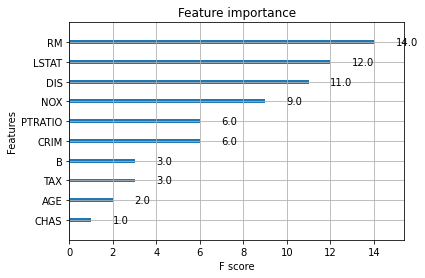

In [7]:
# Feature importance visual

# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":3}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=10)

# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()

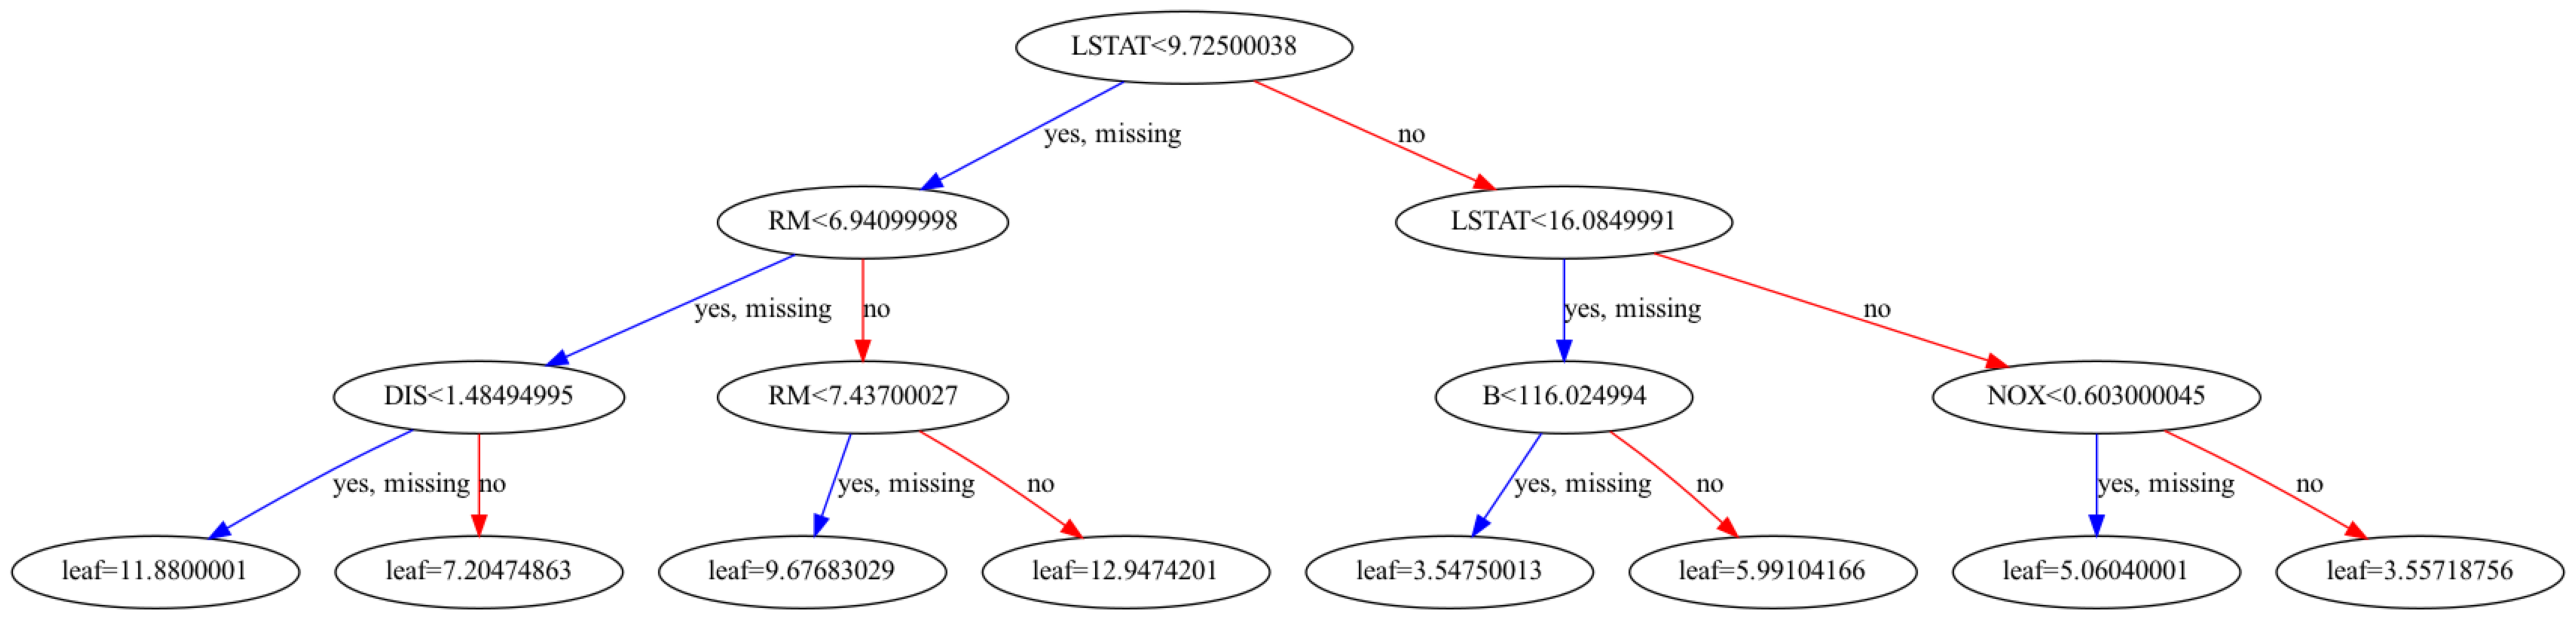

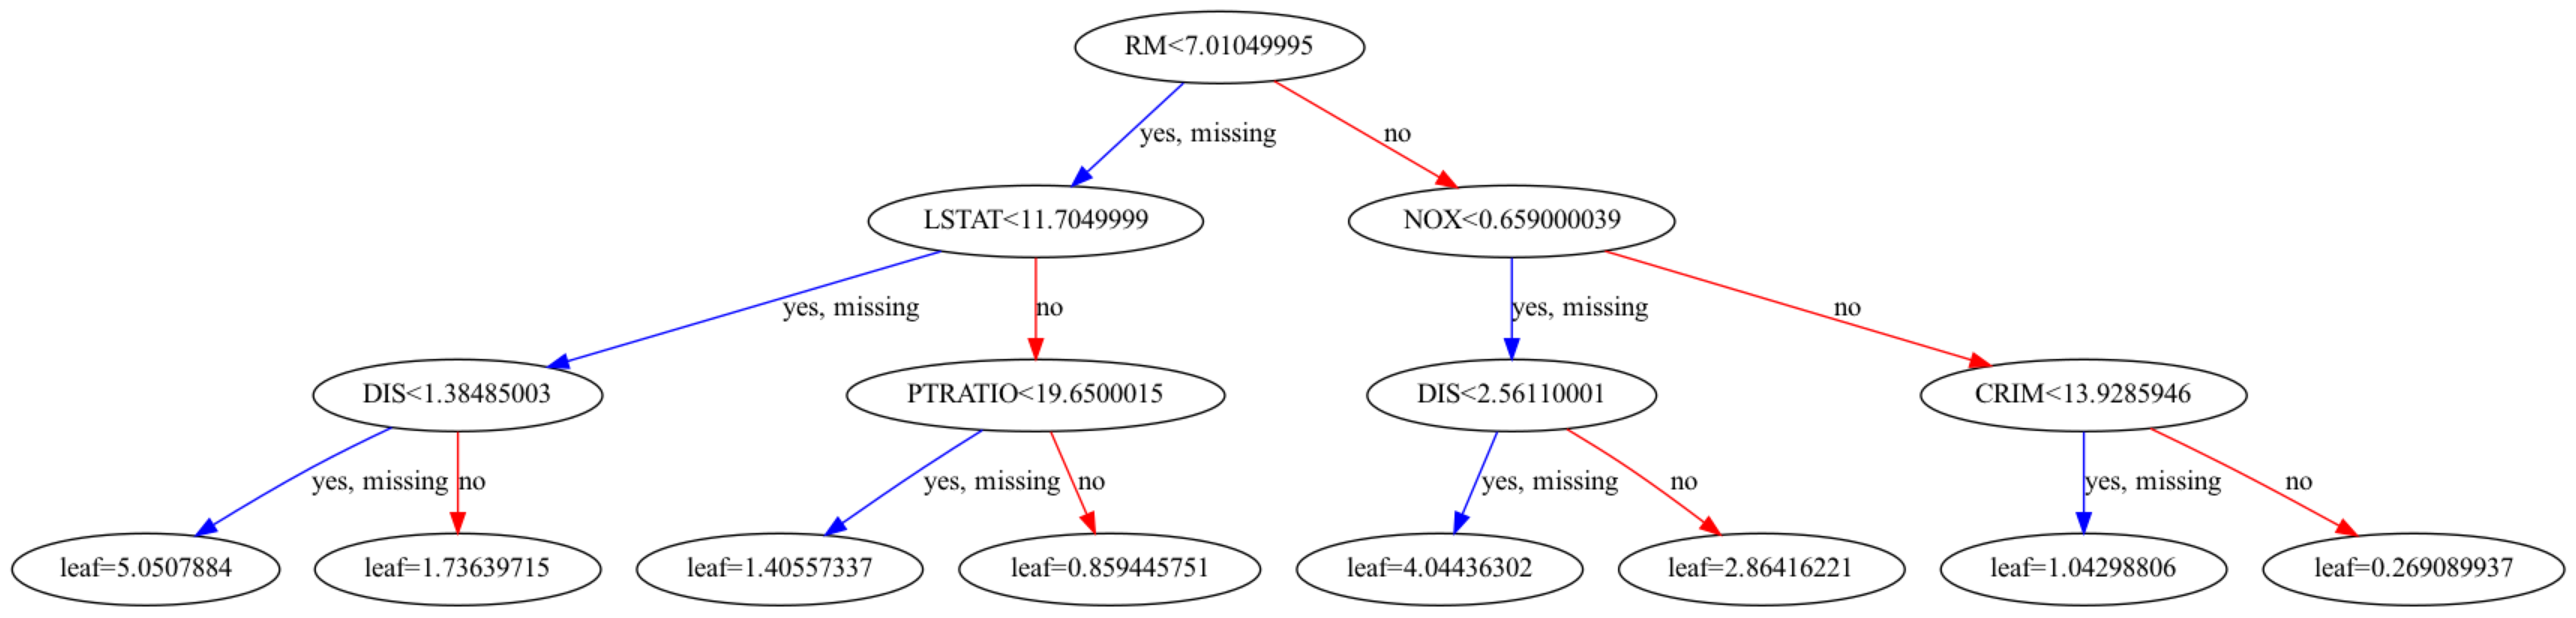

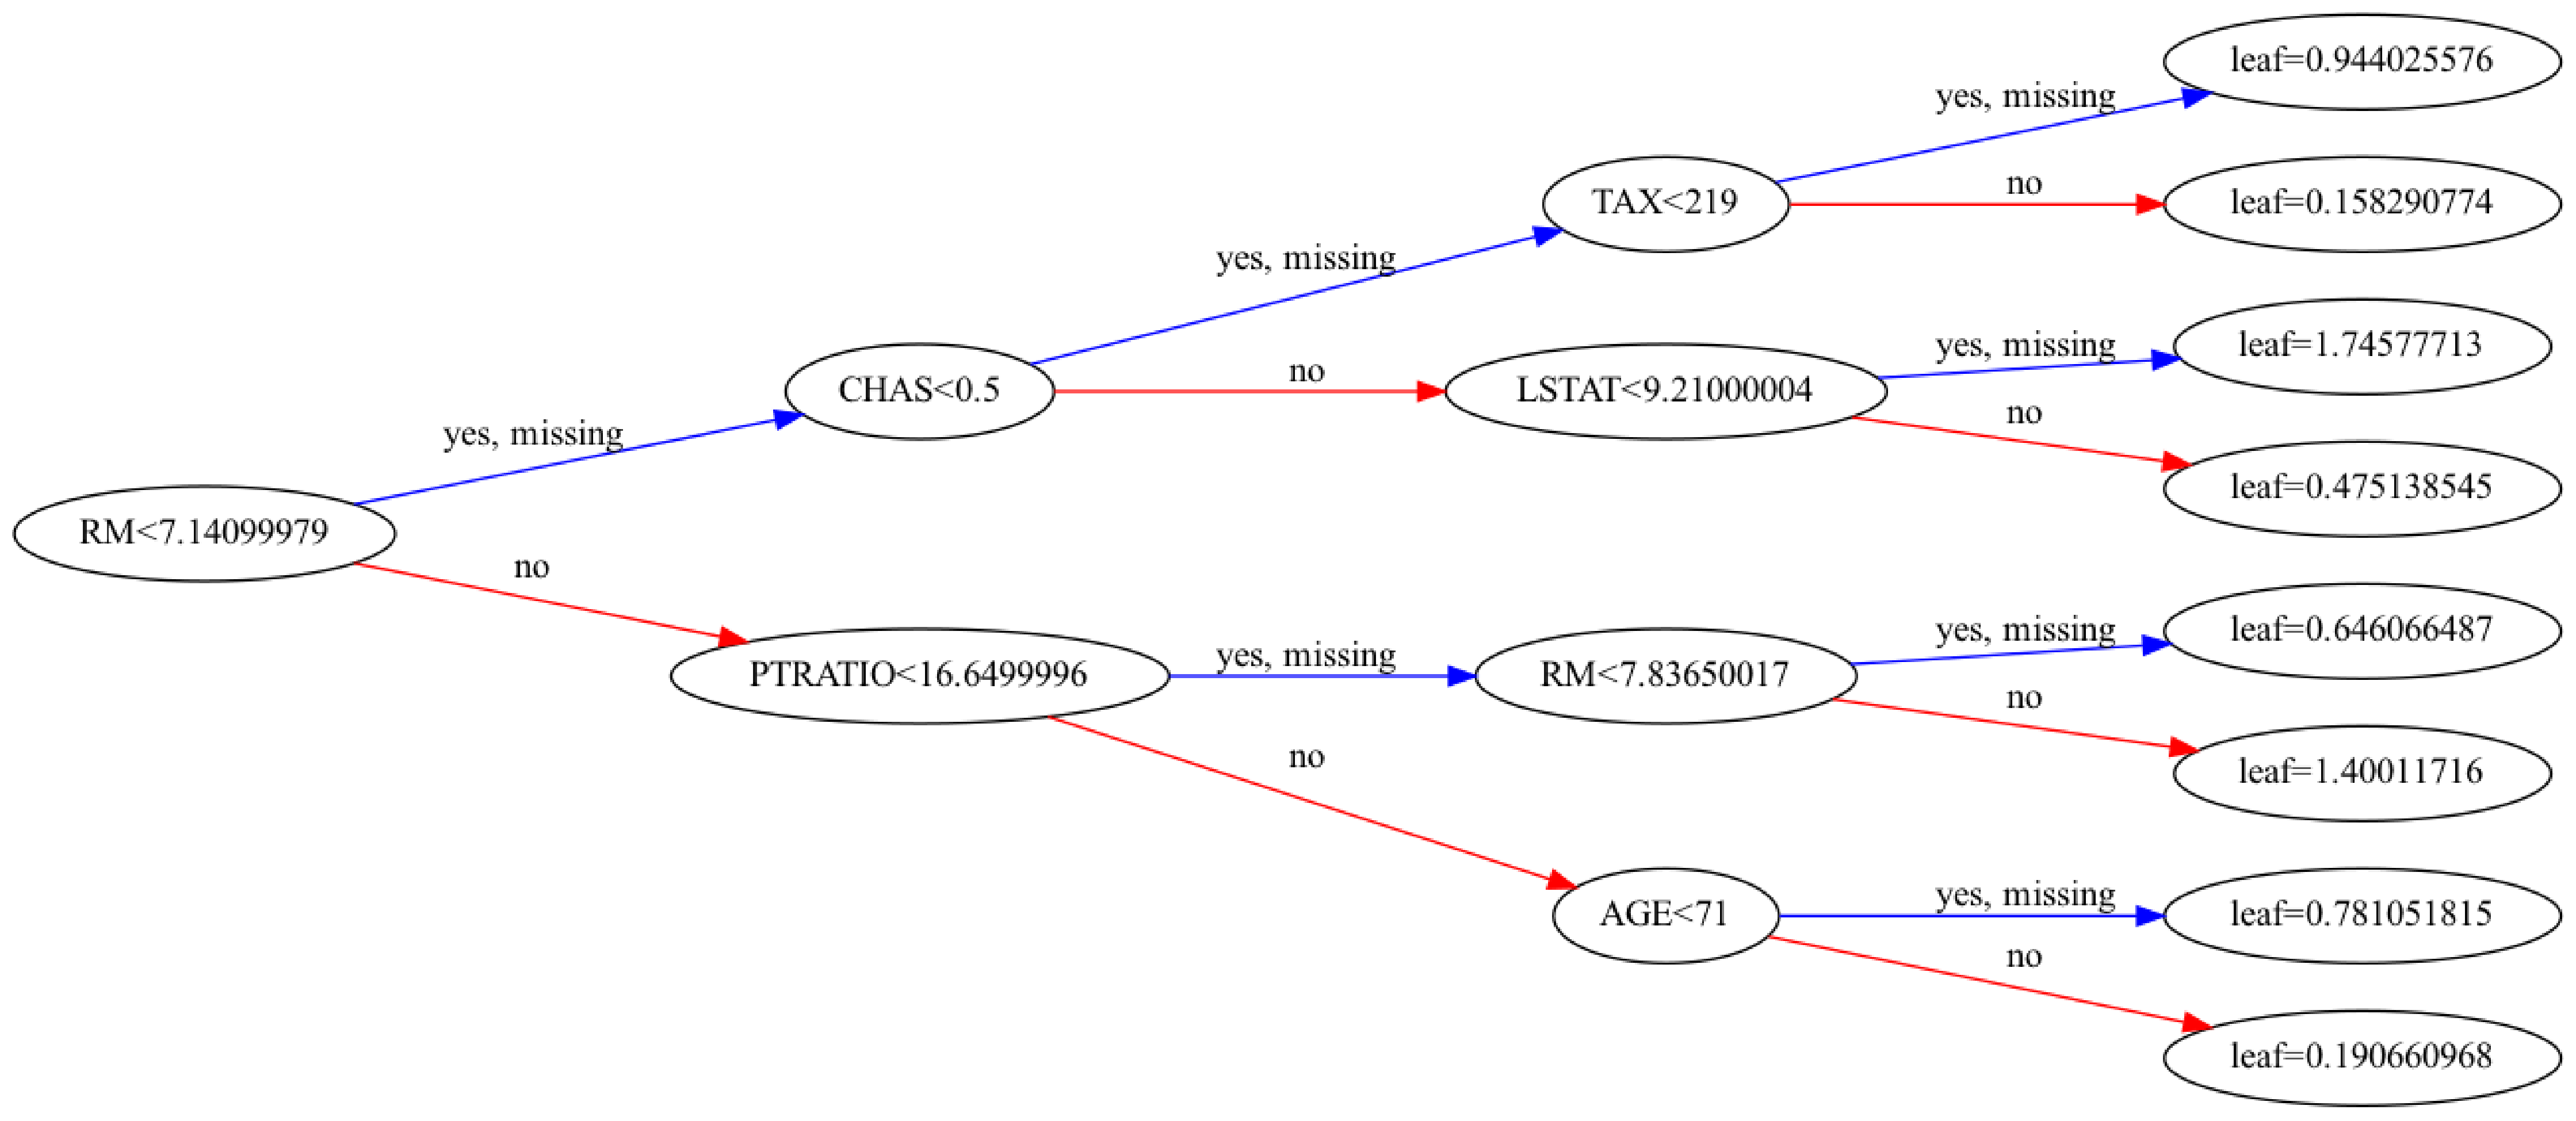

In [25]:
# Tree visual

# Tree size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 80,60

# Plot the first tree
xgb.plot_tree(xg_reg, num_trees=0)
plt.show()

# Plot the fifth tree
xgb.plot_tree(xg_reg, num_trees=4)
plt.show()

# Plot the last tree sideways
xgb.plot_tree(xg_reg, num_trees=9, rankdir='LR')
plt.show()

#### Tuning the model parameters

In [29]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary for each tree: params 
params = {"objective":"reg:squarederror", "max_depth":3}

# Create list of number of boosting rounds
num_rounds = [5, 10, 15]

# Empty list to store final round rmse per XGBoost model
final_rmse_per_round = []

# Iterate over num_rounds and build one model per num_boost_round parameter
for curr_num_rounds in num_rounds:

    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=3,
                        num_boost_round=curr_num_rounds, metrics="rmse", as_pandas=True, seed=123)
    display('Results for', curr_num_rounds, cv_results.tail(1))
    
    # Append final round RMSE
    final_rmse_per_round.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
num_rounds_rmses = list(zip(num_rounds, final_rmse_per_round))
print(pd.DataFrame(num_rounds_rmses,columns=["num_boosting_rounds","rmse"]))

'Results for'

5

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
4,5.253683,0.099751,5.950357,0.117616


'Results for'

10

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
9,2.477342,0.095176,3.784688,0.275057


'Results for'

15

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
14,1.968184,0.092139,3.525731,0.316728


   num_boosting_rounds      rmse
0                    5  5.950357
1                   10  3.784688
2                   15  3.525731


In [30]:
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,17.146654,0.019700,17.231121,0.021329
1,12.429111,0.023540,12.691818,0.054860
2,9.123616,0.051399,9.459222,0.040069
3,6.842408,0.069117,7.354610,0.051175
4,5.253683,0.099751,5.950357,0.117616
5,4.193022,0.103737,5.041234,0.177691
6,3.482292,0.090847,4.471648,0.252456
7,2.998153,0.094902,4.124211,0.239393
8,2.692617,0.101723,3.918025,0.255362
9,2.477342,0.095176,3.784688,0.275057


#### Automated boosting round selection using early_stopping

 - Instead of attempting to cherry pick the best possible number of boosting rounds, you can very easily have XGBoost automatically select the number of boosting rounds for you within xgb.cv(). This is done using a technique called early stopping.


 - Early stopping works by testing the XGBoost model after every boosting round against a hold-out dataset and stopping the creation of additional boosting rounds (thereby finishing training of the model early) if the hold-out metric ("rmse" in our case) does not improve for a given number of rounds. Here you will use the early_stopping_rounds parameter in xgb.cv() with a large possible number of boosting rounds (50). Bear in mind that if the holdout metric continuously improves up through when num_boost_rounds is reached, then early stopping does not occur.
 

In [34]:
# Create your housing DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary for each tree: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-validation with early stopping: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         17.131356        0.020617       17.223397       0.067773
1         12.382814        0.025832       12.619156       0.132110
2          9.063982        0.037020        9.505188       0.117293
3          6.726435        0.034949        7.339914       0.120754
4          5.102424        0.045689        5.954197       0.137525
5          3.976571        0.049928        5.043778       0.198929
6          3.195956        0.061089        4.436178       0.214428
7          2.694113        0.066253        4.066126       0.295735
8          2.341284        0.050819        3.837729       0.326882
9          2.099043        0.052466        3.667520       0.352621
10         1.931934        0.042599        3.573348       0.360856
11         1.824035        0.047074        3.510915       0.370727
12         1.713532        0.058416        3.469601       0.372425
13         1.628079        0.058896        3.441818       0.39

#### Common tunable parameters

 - learning rate (eta)
     - determines how quickly the model fits to residual errors using additional base learners
     - a low learning rate requires additional boosting rounds to achieve the same reduction in residual error
     
 - gamma: min loss reduction to create new tree split
 - lambda: L2 reg on leaf weights
 - alpha: L1 reg on leaf weights
 - max_depth: max depth each tree is allowed to grow into during any given boosting round
 
 - subsample {0,1}: is the fraction of samples used per tree (fraction of training set that can be used per boosting round)
     - if the value is low (high) it might lead to underfitting (overfitting) problems
 
 - colsample_bytree {0,1}: is the fraction of features available per boosting round
     - if the value is low (high) it might lead to underfitting -similar to providing additional regularization to the model - (overfitting) problems

In [35]:
# Learning rate tuning


# Create your housing DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary for each tree (boosting round)
params = {"objective":"reg:squarederror", "max_depth":3}

# Create list of eta values and empty list to store final round rmse per xgboost model
eta_vals = [0.001, 0.01, 0.1]
best_rmse = []

# Systematically vary the eta
for curr_val in eta_vals:

    params["eta"] = curr_val
    
    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=3,
                        num_boost_round=10, early_stopping_rounds=5,
                        metrics="rmse", as_pandas=True, seed=123)
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(eta_vals, best_rmse)), columns=["eta","best_rmse"]))

     eta  best_rmse
0  0.001  23.649514
1  0.010  21.740977
2  0.100   9.473432


In [37]:
# Max depth tuning

# Create the parameter dictionary
params = {"objective":"reg:squarederror"}

# Create list of max_depth values
max_depths = [2, 5, 10, 20]
best_rmse = []

# Systematically vary the max_depth
for curr_val in max_depths:

    params["max_depth"] = curr_val
    
    # Perform cross-validation
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=2,
                 num_boost_round=10, early_stopping_rounds=5,
                 metrics="rmse", as_pandas=True, seed=123)
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(max_depths, best_rmse)),columns=["max_depth","best_rmse"]))

   max_depth  best_rmse
0          2   4.097684
1          5   3.867900
2         10   3.840242
3         20   3.806038


In [39]:
# Colsample by tree tuning

# Create the parameter dictionary
params={"objective":"reg:squarederror","max_depth":3}

# Create list of hyperparameter values
colsample_bytree_vals = [0.1, 0.5, 0.8, 1]
best_rmse = []

# Systematically vary the hyperparameter value 
for curr_val in colsample_bytree_vals:

    params["colsample_bytree"] = curr_val
    
    # Perform cross-validation
    cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=2,
                 num_boost_round=10, early_stopping_rounds=5,
                 metrics="rmse", as_pandas=True, seed=123)
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(colsample_bytree_vals, best_rmse)), columns=["colsample_bytree","best_rmse"]))

   colsample_bytree  best_rmse
0               0.1   5.199025
1               0.5   3.909301
2               0.8   3.783772
3               1.0   3.928074


#### Grid search and random search

 - Grid search
     - searches exhaustively over a given set of hyperparameters
     - the number of models = number of distinct values per hyperparam multiplied across each hyperparam
     - picks the model with the best cross-validated evaluation metric value
 
 - Random search
     - given a range of hyperparam values and a set number of iterations, during each iteration a value in the range of specified values for each hyperparam is randomly selected
     - the model is trained and evaluated at each iteration
     - selecte the model with the best metric
 
 - The search space size can be massive for Grid Search in certain cases, whereas for Random Search the number of hyperparameters has a significant effect on how long it takes to run

In [40]:
# Create the parameter grid: gbm_param_grid
gbm_param_grid = {
    'colsample_bytree': [0.3, 0.7],
    'n_estimators': [50],
    'max_depth': [2, 5]
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor()

# Perform grid search: grid_mse
grid_mse = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid,
                        scoring='neg_mean_squared_error', cv=4, verbose=1)
grid_mse.fit(X, y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best parameters found:  {'colsample_bytree': 0.7, 'max_depth': 2, 'n_estimators': 50}
Lowest RMSE found:  4.724367588010837


In [43]:
# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'n_estimators': [25],
    'max_depth': range(2, 12)
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor(n_estimators=10)

# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid,
                                    n_iter=5, scoring='neg_mean_squared_error', cv=4, verbose=1)
randomized_mse.fit(X, y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ",randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best parameters found:  {'n_estimators': 25, 'max_depth': 5}
Lowest RMSE found:  4.4285973439145945


#### Sklearn pipelines

 - List of named 2-tuples (name, pipeline step) as input
 - Can contain any number of estimator or transformer objects compatible with scikit-learn
 - Implements fit and predict methods
 - Can be used as input estimator into grid/randomized search and cross validation methods

In [49]:
import xgboost as xgb
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

In [91]:
names = ["crime","zone","industry","charles","no", "rooms","age", 
         "distance","radial","tax", "pupil","aam","lower","med_price"]

df_b = pd.DataFrame(boston['data'])
df_b[13] = boston['target']
df_b.columns = names

X, y = df_b.iloc[:,:-1], df_b.iloc[:,-1]

xgb_pipeline = Pipeline([("st_scaler",StandardScaler()), 
                        ("xgb_model",xgb.XGBRegressor())])

gbm_param_grid = {'xgb_model__subsample': np.arange(.05, 1, .05), 
                  'xgb_model__max_depth': np.arange(3,20,1),
                  'xgb_model__colsample_bytree': np.arange(.1,1.05,.05) }

randomized_neg_mse = RandomizedSearchCV(estimator=xgb_pipeline, 
                                        param_distributions=gbm_param_grid, n_iter=10,  
                                        scoring='neg_mean_squared_error', cv=4)

randomized_neg_mse.fit(X, y)

print("Best rmse: ", np.sqrt(np.abs(randomized_neg_mse.best_score_)))
print("Best model: ", randomized_neg_mse.best_estimator_)

Best rmse:  4.895732971469177
Best model:  Pipeline(steps=[('st_scaler', StandardScaler()),
                ('xgb_model',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.7500000000000002,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=8, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
        